## Filtering for Hardy-Weinberg Equilibrium


This notebook filters out loci that are out of HWE for BATCH 7. 

#### 9/1/2017


<br>
### 1. Convert final file to genepop

In [1]:
cd ../scripts/PostStacksFilter_rSNP/

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/scripts/PostStacksFilter_rSNP


In [3]:
!python matrix_conversion_forGENEPOP_2.py -h

usage: matrix_conversion_forGENEPOP_2.py [-h] [-f INPUT] [-o OUTPUT]
                                         [-m POPMAP] [-pm PATH_POPMAP]
                                         [-ps PATH_STACKS] [-t TITLE]

convert matrix file (loci as column headers) to a genepop file.

optional arguments:
  -h, --help            show this help message and exit
  -f INPUT, --input INPUT
                        2 x 2 matrix file with loci as column headers, one row
                        per sample.
  -o OUTPUT, --output OUTPUT
                        output file in genepop format
  -m POPMAP, --popmap POPMAP
                        population map file
  -pm PATH_POPMAP, --path_popmap PATH_POPMAP
                        path to population map file
  -ps PATH_STACKS, --path_stacks PATH_STACKS
                        path to stacks files, including input file
  -t TITLE, --title TITLE
                        title for your genepop file


In [ ]:
!python matrix_conversion_forGENEPOP_2.py \
-f batch_7.filteredLoci60_filteredMAF_Loci2_filteredIndivids \
-o batch_7.filteredLoci20_filteredMAF_filteredIndivids_genepop.txt \
-m PopMap_L1-5_mdFilter_b7.txt \
-pm ../ \
-ps ../../stacks_b7_wgenome \
-t "PCod Korea batch 7, filtered for missing data in loci & individuals, MAF"

<br>
<br>
### 2. Run GENEPOP

options `1... Hardy-Weinberg exact tests >> 3...test for each locus in each population, Probability test`

In [4]:
cd ../../analyses

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/analyses


In [5]:
!mkdir genepop

*moved all genepop output files (from batch 7 and previous batches) into this folder*

<br>
### 3. Parse GENEPOP output


Genepop put out a file batch_7...txt.P that contains, at the bottom, a list of by-locus p-values and Fis estimates by population.

I created the following script to parse out this information into TWO tab-delimited files that are organized as 2x2 charts: locus in the first column, and population in the first row. The first file gives calculated HWE p-values, and the second file contains the W&C Fis estimates.

In [6]:
!python parse_genepop_HWEbylocus.py -h

usage: parse_genepop_HWEbylocus.py [-h] [-p P] [-op OUTPUTPVAL]
                                   [-of OUTPUTFIS]

optional arguments:
  -h, --help            show this help message and exit
  -p P, --P P           path & name of .P file output from genepop
  -op OUTPUTPVAL, --OUTPUTpval OUTPUTPVAL
                        path & name of the output file for the parsed HWE
                        pvalues
  -of OUTPUTFIS, --OUTPUTfis OUTPUTFIS
                        path & name of the output file for the parsed Fis
                        values


In [7]:
!python parse_genepop_HWEbylocus.py \
-p ../stacks_b7_wgenome/batch_7_filteredLoci20_filteredMAF_filteredIndivids_genepop.txt.P \
-op genepop/batch7/batch_7_HWEpvals_parsed.txt \
-of genepop/batch7/batch_7_HWEfis_parsed.txt

generating dictionaries of pvalues and fis values...
writing output to files...
done.


<br>

### 4. Graph distribution of Loci out of HWE

In [8]:
cd genepop/batch7

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/analyses/genepop/batch7


In [9]:
!head batch_7_HWEpvals_parsed.txt

# parsed GENEPOP output, HWE p-values by locus by population. #
locus	PO031715	GEO012315	NA021015	YS	JUK07	JB121807	JB021108	BOR07	GEO020414	Percent.Sig
18468_137	1.0000	NA	1.0000	1.0000	1.0000	NA	NA	0.1070	NA	0.0
10535_53	0.0778	1.0000	0.0811	1.0000	0.1296	0.0391	0.5669	1.0000	0.5736	0.111111111111
15205_47	0.2136	NA	0.5384	0.4268	NA	1.0000	1.0000	0.2145	0.2198	0.0
8929_47	NA	1.0000	1.0000	1.0000	1.0000	1.0000	1.0000	NA	1.0000	0.0
21723_123	0.5621	0.3442	0.4111	0.4655	1.0000	1.0000	1.0000	1.0000	0.2265	0.0
17078_96	1.0000	1.0000	NA	1.0000	1.0000	1.0000	1.0000	NA	NA	0.0
15588_70	NA	NA	NA	NA	NA	NA	NA	1.0000	NA	0.0
13324_59	0.0037	1.0000	NA	NA	1.0000	0.3107	0.2941	0.0244	NA	0.222222222222


In [16]:
infile = open("batch_7_HWEpvals_parsed.txt", "r")

percents = []
loci_list = []
na_count = 0

for line in infile:
    if "locus" not in line:
        if line.strip().split()[10]:
            new_percent = float(line.strip().split()[10])
            percents.append(new_percent)
            loci_list.append(line.strip().split()[0])

infile.close()

In [17]:
import numpy as np
import matplotlib.pyplot as plt

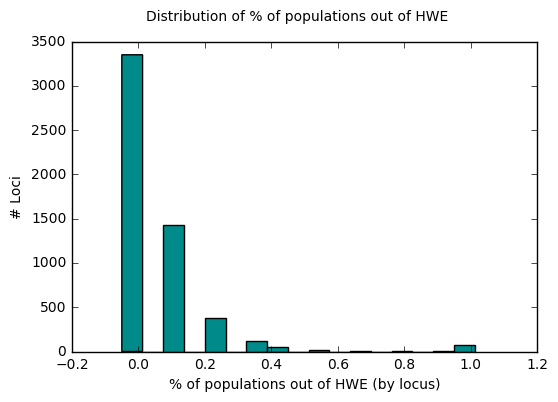

In [18]:
plt.hist(percents, bins = np.arange(-0.1, 1, .0625)+0.05, color = "darkcyan")
plt.suptitle("Distribution of % of populations out of HWE")
plt.xlabel("% of populations out of HWE (by locus)")
plt.ylabel("# Loci")
plt.show()

In [22]:
plt.close()

<br>
<br>
### 5. Use multiple testing technique to generate chi-square value for each locus 

The `Biometrics book` proposes a method to coerce multiple tests into a chi-square distribution that then allows you to test for significance.

At each locus: (1) Sum the natural logs of the p-values, (2) Add these together, (3) multiple by -2 to generate a chi-square value, and (4) complete a chi-square test with [n_pops x 2] degrees of freedom.

In [23]:
from scipy.stats import chisqprob

In [24]:
import numpy as np

In [25]:
pwd

u'/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/analyses/genepop/batch7'

In [27]:
## STEP ONE: conduct chisquare and determine loci out of HWE. 
## write results to a file and save a list of the loci out of HWE. 

infile = open("batch_7_HWEpvals_parsed.txt", "r")
outfile = open("batch_7_HWEchisquare.txt", "w")

outfile.write("locus\tChiSquare\tdf\tpvalue\n")

sig_count = 0
loci_to_discard = []

for line in infile:
    if "locus" not in line:
        linelist= line.strip().split()
        outfile.write(linelist[0]) #write locus name to outfile
        sum = 0 #sum of ln(pvals)
        n_pops = 0 # number of pops with pvals (some will have NAs)
        for i in range(1,8):
            if linelist[i] != "NA" and float(linelist[i]) == 0.0:
                newval = np.log(float(0.00000000001))
                sum += newval
                n_pops += 1
            elif linelist[i] != "NA" and float(linelist[i]) != 0.0:
                newval = np.log(float(linelist[i]))
                sum += newval
                n_pops += 1
        chisquare = float(-2) * float(sum)
        df = n_pops * 2
        outfile.write("\t" + str(chisquare) + "\t" + str(df))
        pvalue = chisqprob(chisquare,df)
        if pvalue < 0.05:
            sig_count += 1
            loci_to_discard.append(linelist[0])
        outfile.write("\t" + str(pvalue) + "\n")
infile.close()
outfile.close()

print "You have ", sig_count, " loci out of HWE."

You have  588  loci out of HWE.


In [28]:
## STEP TWO: rewrite the file of HWEpvals by locus by population, 
## excluding those loci out of HWE. 

infile = open("batch_7_HWEpvals_parsed.txt", "r")
outfile = open("batch_7_HWEpvals_filtered.txt", "w")

locus_count = 0

for line in infile:
    if line.startswith("#"):
        outfile.write("# parsed GENEPOP output, HWE p-values by locus by population FILTERED #\n")
    elif line.startswith("locus"):
        outfile.write(line)
    else:
        locus = line.strip().split()[0]
        if locus not in loci_to_discard:
            outfile.write(line)
            locus_count += 1
infile.close()
outfile.close()
print locus_count, " loci written to output file."

4859  loci written to output file.


<br>
<br>
### Plot new distribution 

In [30]:
infile = open("batch_7_HWEpvals_filtered.txt", "r")

percents = []
loci_list = []

for line in infile:
    if "locus" not in line and "#" not in line:
        new_percent = float(line.strip().split()[10])
        percents.append(new_percent)
        loci_list.append(line.strip().split()[0])

infile.close()

In [31]:
import numpy as np
import matplotlib.pyplot as plt

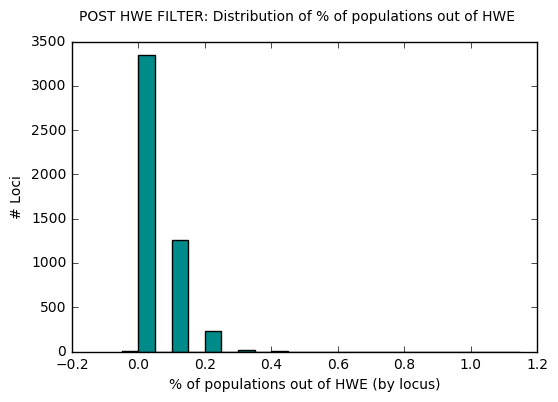

In [32]:
plt.hist(percents, bins = np.arange(-0.1, 1.1, .05)+0.05, color = "darkcyan")
plt.suptitle("POST HWE FILTER: Distribution of % of populations out of HWE")
plt.xlabel("% of populations out of HWE (by locus)")
plt.ylabel("# Loci")
plt.show()

In [33]:
plt.close()

<br>
<br>
### Remove loci that are out of HWE from final genepop

To do this, I'll actually be working with the matrix file that was the base of the `genepop` file created for GENEPOP program. 

If you are working with a `.csv` file, or with a file that has sample names as columns, see the end of [this notebook](https://github.com/mfisher5/PCod-US-repo/blob/master/notebooks/Stacks%20batch%202%20-%20filter%20for%20HWE.ipynb) for alternative code. 

In [35]:
pwd

u'/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/analyses/genepop/batch7'

In [36]:
cd ../../

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/analyses


In [65]:
old = open("../stacks_b7_wgenome/batch_7.filteredLoci60_filteredMAF_Loci2_filteredIndivids", "r")
locifile = open("genepop/batch7/batch_7_HWEpvals_filtered.txt", "r")
new = open("../stacks_b7_wgenome/batch_7.filteredLoci20_filteredMAF_filteredIndivids_filteredHWE.txt", "w")
blacklisted = open("../stacks_b7_wgenome/batch_7.filteredLoci20_filteredMAF_filteredIndivids_filteredHWE_BAD.txt", "w")

## Note that my matrix file here has loci as column header, so I need to transpose it!
data_matrix = []
for line in old:
	tmp_line = ''
	tmp_line += line.strip()
	data_matrix.append(tmp_line.split(' '))
old.close()

transposed = zip(*data_matrix)

#write sample names to new file
new.write("\t".join(transposed[0]) + "\n")
blacklisted.write("\t".join(transposed[0]) + "\n")

#get list of loci that should be retained
loci_to_keep = []

for line in locifile: 
    if "locus" not in line:
        loci_to_keep.append(line.strip().split()[0]) 
locifile.close()

print "Preparing to copy ", len(loci_to_keep), " loci from old file"
print ""


cp_count = 0
rm_count = 0
loci_kept = []

for line in transposed[1:]: 
    locusID = line[0]
    if locusID in loci_to_keep:
        new.write("\t".join(line) + "\n")
        cp_count += 1
        loci_kept.append(locusID)
    else:
        blacklisted.write("\t".join(line) + "\n")
        rm_count += 1
new.close()
blacklisted.close()

print "Wrote ", cp_count, " loci to new matrix file."
print "Removed ", rm_count, " loci."

if len([i for i in loci_to_keep if i in loci_kept]) == len(loci_to_keep):
    print "All loci to keep were copied."
else:
    print "uhoh! not all loci to keep were copied."
    print "the following loci were not copied over:"
    print [i for i in loci_to_keep if i not in loci_kept]

Preparing to copy  4859  loci from old file

Wrote  4859  loci to new matrix file.
Removed  588  loci.
All loci to keep were copied.


<br>
<br>
### Create genepop file for R, GENEPOP analyses. 

In [66]:
pwd

u'/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/analyses'

In [67]:
cd ../scripts/PostStacksFilter_rSNP/

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/scripts/PostStacksFilter_rSNP


In [72]:
!python matrix_conversion_forGENEPOP.py -h

usage: matrix_conversion_forGENEPOP.py [-h] [-f INPUT] [-o OUTPUT] [-m POPMAP]
                                       [-pm PATH_POPMAP] [-ps PATH_STACKS]
                                       [-t TITLE] [-split SPLIT_BY]

convert matrix file (samples as column headers) to a genepop file.

optional arguments:
  -h, --help            show this help message and exit
  -f INPUT, --input INPUT
                        2 x 2 matrix file with samples as column headers, one
                        row per locus.
  -o OUTPUT, --output OUTPUT
                        output file in genepop format
  -m POPMAP, --popmap POPMAP
                        population map file
  -pm PATH_POPMAP, --path_popmap PATH_POPMAP
                        path to population map file
  -ps PATH_STACKS, --path_stacks PATH_STACKS
                        path to stacks files, including input file
  -t TITLE, --title TITLE
                        title for your genepop file
  -split SPLIT_BY, --split_by SPLIT_BY
        

In [75]:
!python matrix_conversion_forGENEPOP.py \
-f batch_7.filteredLoci20_filteredMAF_filteredIndivids_filteredHWE.txt \
-o batch_7_filteredLoci20_filteredMAF_filteredIndivids_filteredHWE_genepop.txt \
-m PopMap_L1-5_mdFilter_b7.txt \
-pm .. \
-ps ../../stacks_b7_wgenome \
-t "PCod Korea Genepop, Lanes 1 -5 (all samples) Final Filtered" \
-split "tab"

You have 9 populations.
These are your populations, with the number of samples in each:
OrderedDict([('Pohang15', 34), ('Geoje15', 37), ('Namhae15', 19), ('YellowSea16', 29), ('Jukbyeon07', 35), ('JinhaeBay07', 44), ('JinhaeBay08', 44), ('Boryeong07', 23), ('Geoje14', 34)])
creating script for part 2...
calling script for part 2...
transposing genotypes matrix...
writing loci into genepop file...
writing genotypes into genepop file by population...
done.


### FINAL GENEPOP FILE: batch_7_filteredLoci20_filteredMAF_filteredIndivids_filteredHWE_genepop.txt